In [15]:
'''
   Quantum optimization with qutip
   
   Author : Chan-young Lee

   Description : This source code is made to change framework
                 from pennylane to qutip and to do some code
                 optimization if possible

'''

# Import Packages

import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.qip.circuit import *

import torch
import matplotlib.pyplot as plt


# Global parameters
tau_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
gamma_ps_global = torch.tensor(0, dtype=torch.float, requires_grad=False)
param_global = torch.tensor([0,0], dtype=torch.float, requires_grad=True)
phi_global = torch.tensor(0, dtype=torch.float, requires_grad=True)

# Defining hamiltonian
H = -0.5*sigmaz()


def dephase_factor(tau):
    """ 
    Calculate the dephasing factor for a given dephasing time tau.

    Args:
        tau (torch.Tensor): Dephasing time.

    Returns:
        torch.Tensor: Dephasing factor.
    """  
    return 1 - torch.exp(-2*tau)


def post_selection(phi):
    """ 
    Perform post-selection on the output of the `circuit` function.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        torch.Tensor: Post-selected density matrix after applying a Kraus operator.
    """
    global param_global, gamma_ps_global
    
    density_matrix = quantumcircuit(phi).ops()[0]

    # Kraus operator for 2*2 matrix
    kraus_op = torch.tensor([
        [torch.sqrt(1 - gamma_ps_global), 0],
        [0,1]
    ], dtype = torch.complex128)

    numerator = kraus_op @ density_matrix @ kraus_op.conj().T
    denominator = torch.trace(numerator)
    rho_ps = numerator / denominator

    return Qobj(rho_ps.numpy())
    

def time_evolution_with_phase_damping(phi):
    """
    Returns trotterized time-evolution gate with phase damping.

    Args:
        H (Qobj): Pre-defined Hamiltonian.
        phi (torch.Tensor) : Phase angle for the quantum gate.

    Returns:
        gate (Qobj) : trotterized time-evolution gate.
    """

    global tau_global

    gamma_dephasing = dephase_factor(tau_global)

    damping = np.sqrt(1 - gamma_dephasing)
    operator = tensor()

    return Qobj(operator, dims=[[2],[2]])


def quantumcircuit(phi):
    """
    Define quantum circuit and returns it.

    Args:
        phi (torch.Tensor): Phase angle for the quantum gate.

    Returns:
        qc (QubitCircuit): Assembled Circuit.
    """

    global param_global
    phi_z = param_global[0]
    theta_x = param_global[1]

    # Circuit declaration
    qc = QubitCircuit(N = 1, num_cbits = 1)

    # Import time evolution with phase damping circuit
    qc.user_gates = {"TimeEvolutionWithDamping" : time_evolution_with_phase_damping}

    # Circuit construction
    qc.add_gate("RX", targets = [0], arg_value = np.pi/2)
    qc.add_gate("TimeEvolutionWithDamping", targets = [0], arg_value = phi)
    qc.add_gate("RZ", targets = [0], arg_value = phi_z)
    qc.add_gate("RX", targets = [0], arg_value = theta_x)

    return qc


c = quantumcircuit(phi_global)

c:\Users\이찬영\AppData\Local\Programs\Python\Python311\Lib\site-packages\qutip\qip\circuit.py:242: UserWarning: Unknown gate TimeEvolutionWithDamping
  warnings.warn("Unknown gate %s" % name)


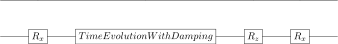

In [16]:
c.svg

## QuTip이랑 PyTorch랑 호환이 안되는데 어카지?

이런 젠장

In [17]:
print(type(c))
sim = CircuitSimulator(c, precompute_unitary=False)

<class 'qutip.qip.circuit.QubitCircuit'>


c:\Users\이찬영\AppData\Local\Programs\Python\Python311\Lib\site-packages\qutip\qobj.py:304: UserWarning: Initializing Qobj from unsupported type: <class 'torch.Tensor'>
  warnings.warn("Initializing Qobj from unsupported type: %s" %


ValueError: The operator dims [1] do not match the target dims [2].